### Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses
from tensorflow.keras.datasets import fashion_mnist
# models used
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
# layers used in models
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
# used to find model shape
from tensorflow.keras import backend as K


### Load the Dataset

In [33]:
P_data = np.load("D:\\Non Windows Stuff\\HPC Research\\Airfoil_Performance_Data.npy")

split = int(P_data.shape[0]/8)
P_train = np.zeros([7*split, P_data.shape[1], P_data.shape[2], P_data.shape[3]])
P_test = np.zeros([split, P_data.shape[1], P_data.shape[2], P_data.shape[3]])
for i in range(0,split):
    P_train[(7*i):7*(i+1),:,:,:] = P_data[(7*i):7*(i+1),:,:,:]
    P_test[i,:,:,:] = P_data[8*i,:,:,:]


P_train = (P_train.astype('float32')).reshape([split*7,121,201,10,1])
P_test = (P_test.astype('float32')).reshape([split,121,201,10,1])

print (P_train.shape)
print (P_test.shape)

(1386, 121, 201, 10, 1)
(198, 121, 201, 10, 1)


## Basic autoencoder

In [5]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    F = [16, 64, 256, 1024]
    #F = F[::-1]
    
    #================ ENCODER ================
    self.encoder = Sequential()
    
    # Input layer
    self.encoder.add(InputLayer(input_shape=(121, 201, 10, 1)))
    
    # Convolution 1 ---- (None,121,201,10,1) --> (None,121,100,8)
    self.encoder.add(Conv3D(F[0],(1,1,10),(1,1,1),padding='valid'))
    self.encoder.add(Reshape([121,201,F[0]]))
    self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    
    # Convolution 2 ---- (None,121,201,8) --> (None,41,34,16)
    self.encoder.add(Conv2D(F[1],(5,9),(3,5),padding='same'))
    self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    
    # Convolution 3 ---- (None,41,34,16) --> (None,21,12,32)
    self.encoder.add(Conv2D(F[2],(3,3),(2,2),padding='same'))
    self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    
    # Convolution 4 ---- (None,21,12,32) --> (None,10,10,64)
    self.encoder.add(Conv2D(F[3],(3,3),(2,2),padding='valid'))
    self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    
    # Prepare output
    self.encoder.add(Flatten())
    outShape = 10*10
    self.encoder.add(Dense(outShape))
    
    #================ DECODER ================
    self.decoder = Sequential()
    
    # Input layer
    self.decoder.add(InputLayer(input_shape=(100,)))
    self.decoder.add(Dense(F[3]*outShape))
    self.decoder.add(Reshape([10,10,F[3]]))
    
    # Deconvolution 2 ---- (None,10,10,64) --> (None,21,12,32)
    self.decoder.add(Conv2DTranspose(F[2],(3,3),(2,2),padding='valid'))
    self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    
    # Deconvolution 3 ---- (None,21,12,32) --> (None,41,34,16)
    self.decoder.add(Conv2DTranspose(F[1],(3,3),(2,2),padding='same',output_padding=(0,0)))
    self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # Deconvolution 4 ---- (None,41,34,16) --> (None,121,201,8)
    self.decoder.add(Conv2DTranspose(F[0],(5,9),(3,5),padding='same',output_padding=(0,0)))
    self.decoder.add(Reshape([121,201,F[0]]))
    self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # Deconvolution 5 ---- (None,121,100,8) --> (None,121,201,10,1)
    self.decoder.add(Reshape([121,201,1,F[0]]))
    self.decoder.add(Conv3DTranspose(1,(1,1,10),(1,1,1),activation='sigmoid',padding='valid'))
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [8]:
# compile the model, MSE is the standard loss function for autoencoders
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

print('\n\n===========================')
print('|||\t Encoder \t|||')
print('===========================')
autoencoder.encoder.summary()
print('\n\n===========================')
print('|||\t Decoder \t|||')
print('===========================')
autoencoder.decoder.summary()



|||	 Encoder 	|||
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 121, 201, 1, 16)   176       
_________________________________________________________________
reshape_2 (Reshape)          (None, 121, 201, 16)      0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 121, 201, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 121, 201, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        46144     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 41, 41, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None

### Train the model with x_test as input and the target output

In [9]:
# input P_train should receive P_train back
autoencoder.fit(P_train, P_train,
                epochs=50,
                shuffle=True,
                validation_data=(P_test, P_test)) # validate with P_test when done

Epoch 1/50
44/44 [==============================] - 11s 69ms/step - loss: 346.9633 - val_loss: 639.3080
Epoch 2/50
44/44 [==============================] - 3s 59ms/step - loss: 346.4145 - val_loss: 639.2920
Epoch 3/50
44/44 [==============================] - 3s 58ms/step - loss: 346.2921 - val_loss: 639.2864
Epoch 4/50
44/44 [==============================] - 3s 58ms/step - loss: 346.2357 - val_loss: 639.2546
Epoch 5/50
44/44 [==============================] - 3s 58ms/step - loss: 346.1997 - val_loss: 639.2796
Epoch 6/50
44/44 [==============================] - 3s 58ms/step - loss: 346.1741 - val_loss: 639.2232
Epoch 7/50
44/44 [==============================] - 3s 58ms/step - loss: 346.1469 - val_loss: 639.2370
Epoch 8/50
44/44 [==============================] - 3s 58ms/step - loss: 346.1212 - val_loss: 639.2164
Epoch 9/50
44/44 [==============================] - 3s 59ms/step - loss: 346.0951 - val_loss: 639.1985
Epoch 10/50
44/44 [==============================] - 3s 58ms/step - loss

### Test the model by encoding and decoding the test data

In [34]:
encoded_imgs = autoencoder.encoder(P_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

print('Test Data Shape')
print(P_test.shape)
print('\nDecoded Data Shape')
print(decoded_imgs.shape)

Test Data Shape
(198, 121, 201, 10, 1)

Decoded Data Shape
(198, 121, 201, 10, 1)


### Plot them (not really images but they should look similar) (only used CL, CD, and CM as R, G, and B

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

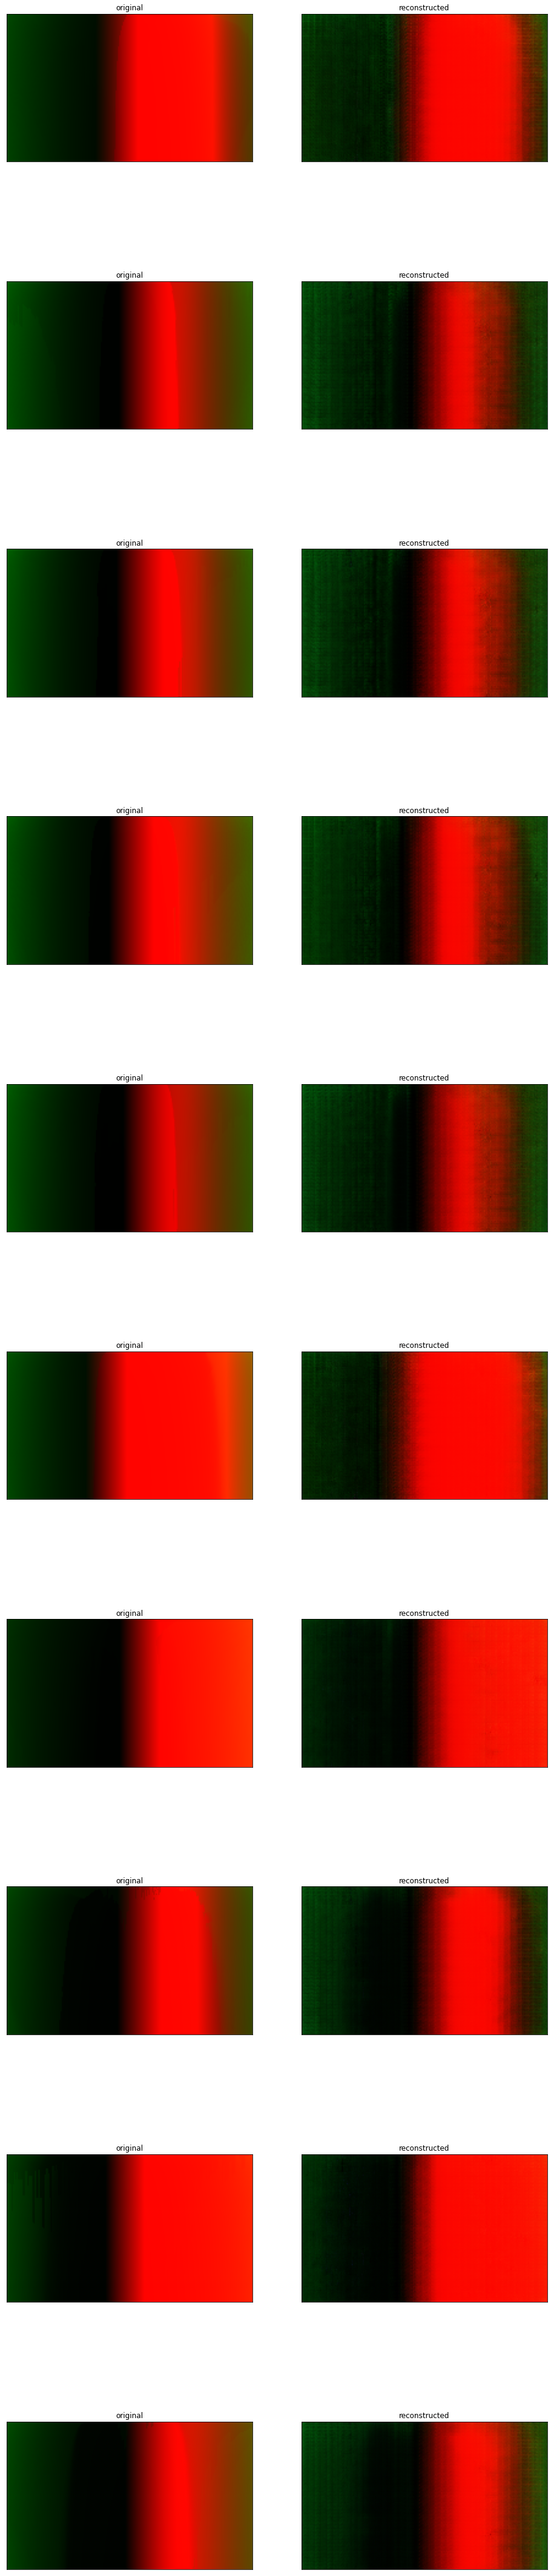

In [35]:
n = 10
plt.figure(figsize=(16, 8*n))
for i in range(n):
    
    # display original
    ax = plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(P_test[i,:,:,0:3,0])
    plt.title("original")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2 * (i + 1) )
    plt.imshow(decoded_imgs[i,:,:,0:3,0])
    plt.title("reconstructed")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()